# Quantum-corrected thermal conductivity of amorphous carbon

# 1. Introduction
- In this example, we show how to perfoem perform quantum correction on the thermal conductivity of amorphous carbon at 300 K and zero pressure using HNEMD simulations and spectral heat current methods. For the details of HNEMD simulations, please refer to the [GPUMD tutorial](https://github.com/brucefan1983/GPUMD/blob/master/examples/empirical_potentials/thermal_transport_nemd_and_hnemd/diffusive/). 


- If you use this apporach in your published work, we kindly ask you to cite the following paper: 
Zheyong Fan, Yanzhou Wang, Penghua Ying, Keke Song, Junjie Wang, Yong Wang, Zezhu Zeng, Ke Xu, Eric Lindgren, J. Magnus Rahm, Alexander J. Gabourie, Jiahui Liu, Haikuan Dong, Jianyang Wu, Yue Chen, Zheng Zhong, Jian Sun, Paul Erhart, Yanjing Su, Tapio Ala-Nissila, [GPUMD: A package for constructing accurate machine-learned potentials and performing highly efficient atomistic simulations](
https://doi.org/10.48550/arXiv.2205.10046), arXiv:2205.10046 [physics.comp-ph].


- For disordered materials, the thermal conductivity can be quantum corrected in a way similar to the quantum correction of the heat capacity as described in [[gu2021jap](https://doi.org/10.1063/5.0069175)]. To achieve this, we first calculate the classical spectral thermal conductivity [[fan2019prb](https://doi.org/10.1103/PhysRevB.99.064308), [gabourie2021](https://doi.org/10.1103/PhysRevB.103.205421)] $\kappa^\mathrm{c}(\omega)$ and include quantum corrections to obtain $\kappa^\mathrm{q}(\omega)$ as follows:
\begin{equation}
    \kappa^\mathrm{q}(\omega) = \kappa^\mathrm{c}(\omega) \frac{x^2 e^x}{(e^x-1)^2},
\end{equation}
where $x=\hbar \omega / k_\mathrm{B} T$.

# 2. Preparing the Inputs
- We use an amorphous carbon containing 64000 atoms. 


- The atomic interactions are described by the [NEP potential](https://github.com/brucefan1983/GPUMD/tree/master/potentials/nep).


## The <code>run.in</code> file:
The <code>run.in</code> input file is given below:<br>
```
potential       ../potentials/nep.txt 0

time_step       1.0

velocity    	300
ensemble        nvt_nhc 300 300 100 
run             100000

ensemble        nvt_nhc 300 300 100
compute_hnemd   1000 0 0 2e-4
compute_shc     5 200 2 500 400
run             2000000
```
 - Thermal conductivity calculations usually require a lot of data to reduce the statistical uncertainty. To this end, we perform a number of independent runs using the above inputs. In GPUMD, the velocities are automatically initialized with different pseudo-random number seeds for different runs. Using the efficient HNEMD method, 5 independent runs (each with a production time of 2 ns) are sufficient to achieve high accuracy (small error bounds).


# 3. Results and Discussion
Based on the [kappa.out](https://gpumd.zheyongfan.org/index.php/The_kappa.out_output_file) and [shc.out](https://gpumd.zheyongfan.org/index.php/The_shc.out_output_file) output files, one can first calculate the classical thermal conductivity and corresponding spectral thermal conductivity. Afterwards, using the quantum correction euqation, one can finally obtain the quantum-corrected thermal conductivity.  

5 independent runs
k = 5.114 ± 0.126

k_quantum_corrected = 3.230 ± 0.089



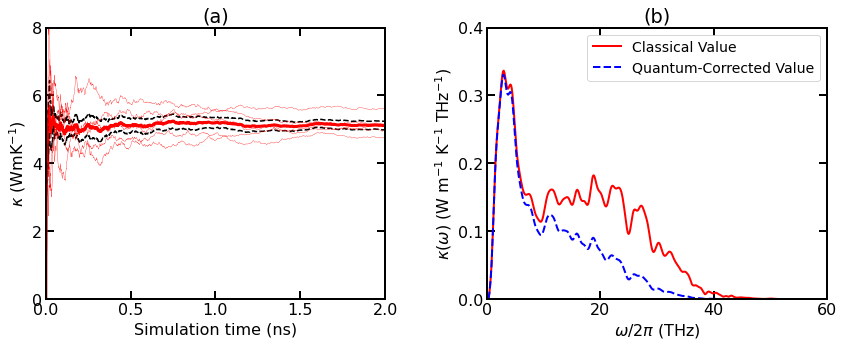

In [7]:
from pylab import *
from thermo.gpumd.data import load_kappa, load_shc
from thermo.gpumd.calc import running_ave, hnemd_spectral_kappa
import pandas as pd

def kappa_std(kappa, run_num):
    std = []
    for i in range(len(kappa)):
        std.append(np.std(kappa[i])/sqrt(run_num))
    return std

def calc_hnemd(path):
    time_step = 1.0  #fs
    output_inter = 1000
    output_num = 2000
    kappa_raw = np.loadtxt(path + "/kappa.out")
    kappa = dict()
    run_num = int(len(kappa_raw)/output_num)
    for i in range(run_num):
        data = kappa_raw[output_num*i:output_num*(i+1)]
        out = dict()
        labels = ['kxi', 'kxo', 'kyi', 'kyo', 'kz']
        for j, key in enumerate(labels):
            out[key] = data[:,j]
        if True not in np.isnan(out['kz']):
            kappa["run%s"%i] = out
    
    kappa_tol = np.zeros((output_num, run_num))
    t = np.arange(1,kappa["run0"]['kxi'].shape[0]+1)*output_inter*time_step/1000  # ps
    i = 0
    for keys in kappa:
        kappa[keys]['kz_ra'] = running_ave(kappa[keys]['kz'],t)
        kappa_tol[:,i] = kappa[keys]['kz_ra']
        i += 1
    
    kappa_tol_ave = np.average(kappa_tol, axis = 1)
    kappa_tol_std = kappa_std(kappa_tol, run_num)
    kappa = dict()
    kappa["t"] = t
    kappa["k_tol"] = kappa_tol
    kappa["k_run"] = kappa_tol_ave
    kappa["k_std"] = kappa_tol_std
    kappa["k"] = kappa_tol_ave[-1]
    kappa["std"] = kappa_tol_std[-1]
    #print(path + ":")
    print("%s independent runs"%run_num)
    print("k = " + format(kappa_tol_ave[-1], ".3f") + " ± " 
      + format(kappa_tol_std[-1], ".3f") + "\n")
    return kappa

def calc_shc_hnemd(path, Fe):
    shc = load_shc(Nc=[200]*5, num_omega=[500]*5, directory=path)
    with open(path+"xyz.in", "r") as fin:
        fin.readline()
        line = fin.readline().split()
    lx = float(line[-3])
    ly = float(line[-2])
    lz = float(line[-1])
    V = lx*ly*lz
    T = 300
    for keys in shc:
        hnemd_spectral_kappa(shc[keys], Fe, T, V)
        shc[keys]['kwi'][shc[keys]['kwi'] < 0] = 0
        shc[keys]['kwo'][shc[keys]['kwo'] < 0] = 0
        shc[keys]['kw'] = shc[keys]['kwi'] + shc[keys]['kwo']
    shc_tol = np.zeros((len(shc["run0"]["kw"]), 5))
    i = 0
    for keys in shc:
        shc_tol[:,i] = shc[keys]['kw']
        i += 1
    shc_tol_ave = np.average(shc_tol, axis = 1)
    shc_output = dict()
    shc_output["nu"] = shc["run0"]["nu"]
    shc_output["tol"] = shc_tol
    shc_output["tol_ave"] = shc_tol_ave
    return shc_output

def shc_quantum_corrected(shc_input):
    shc_correct = np.zeros((len(shc_input['nu']), 5))
    for i in range(len(shc_input['nu'])):
        for j in range(5):
            r = 6.62607015e-34/1.38065e-23 #h/k_B, unit in K*s
            x = r*shc_input['nu'][i]*1e12/300 #dimensionless
            shc_correct[i] = shc_input['tol'][i] * x**2 * exp(x) / (exp(x) - 1)**2 
    kappa_quantum = [trapz(shc_correct[:, i], shc_input['nu']) for i in range(5)]
    kappa_quantum_ave = np.average(kappa_quantum)
    kappa_quantum_std = np.std(kappa_quantum)/sqrt(5)
    print("k_quantum_corrected = " + format(kappa_quantum_ave, ".3f") + " ± " 
    + format(kappa_quantum_std, ".3f") + "\n")
    return shc_correct

def plot1(x, y, yerr, color, shape,label):
    errorbar(x, y, yerr=yerr,
                 fmt = shape,
                 ecolor = color,
                 elinewidth = 2.0,
                 ms = 12,
                 mfc = color,
                 mec = "grey",
                 alpha = 0.8,
                 capsize = 5,
                 barsabove = True,
                 label = label)     
    
aw = 2
fs = 16
font = {'size'   : fs}
matplotlib.rc('font', **font)
matplotlib.rc('axes' , linewidth=aw)
def set_fig_properties(ax_list):
    tl = 8
    tw = 2
    tlm = 4
    for ax in ax_list:
        ax.tick_params(which='major', length=tl, width=tw)
        ax.tick_params(which='minor', length=tlm, width=tw)
        ax.tick_params(which='both', axis='both', direction='in', right=True, top=True)
        
k = calc_hnemd("./")
shc = calc_shc_hnemd("./", 2e-4)
shc_correct = shc_quantum_corrected(shc)

figure(figsize=(14, 5))
subplot(1, 2, 1)
set_fig_properties([gca()])
plot(k['t']*0.001, k['k_run'], color="red", linewidth=3)
plot(k['t']*0.001, k['k_run']+k['k_std'], color = "black", linewidth=1.5, linestyle="--")
plot(k['t']*0.001, k['k_run']-k['k_std'], color = "black", linewidth=1.5, linestyle="--")
for j in range(k['k_tol'].shape[1]):
    plot(k['t']*0.001, k['k_tol'][:,j], color = "red", linewidth=0.3)
xlim([0, 2])
ylim([0, 8])
gca().set_xticks(np.linspace(0, 2, 5))
gca().set_yticks(np.linspace(0, 8, 5))
subplots_adjust(wspace=0.1, hspace=0.15)
xlabel(r'Simulation time (ns)')
ylabel(r'$\kappa$ (WmK$^{-1}$)')
title('(a)')

subplot(1, 2, 2)
set_fig_properties([gca()])
plot(shc['nu'], shc['tol_ave'],linewidth=2, color='red', label = "Classical Value")
plot(shc['nu'], np.average(shc_correct, axis=1), linewidth=2, linestyle="--", 
          color='blue', label = "Quantum-Corrected Value")
xlim([0, 60])
gca().set_xticks(linspace(0, 60, 4))
ylim([0, 0.4])
gca().set_yticks(linspace(0, 0.4, 5))
legend(fontsize=14)
ylabel(r'$\kappa$($\omega$) (W m$^{-1}$ K$^{-1}$ THz$^{-1}$)')
xlabel(r'$\omega$/2$\pi$ (THz)')
title('(b)')

subplots_adjust(wspace = 0.3)

- The thermal conductivity of the amorphous carbon structure (with a mass density of 3.0 g/cm$^3$ at 300 K is determined to be 5.1 $\pm$ 0.1} Wm$^{-1}$K$^{-1}$, where the statistical error is calculated as the standard error [[haile1992book]](https://dl.acm.org/doi/abs/10.5555/531139).


- The quantum-corrected thermal conductivity at 300 K is 3.2 $\pm$ 0.1Wm$^{-1}$K$^{-1}$.

# 4. References
- [Fan 2022] Zheyong Fan, Yanzhou Wang, Penghua Ying, Keke Song, Junjie Wang, Yong Wang, Zezhu Zeng, Ke Xu, Eric Lindgren, J. Magnus Rahm, Alexander J. Gabourie, Jiahui Liu, Haikuan Dong, Jianyang Wu, Yue Chen, Zheng Zhong, Jian Sun, Paul Erhart, Yanjing Su, Tapio Ala-Nissila, [GPUMD: A package for constructing accurate machine-learned potentials and performing highly efficient atomistic simulations](
https://doi.org/10.48550/arXiv.2205.10046), arXiv:2205.10046 [physics.comp-ph].

- [Haile 1992] J. M. Haile, Molecular Dynamics Simulation: Elementary Methods (John Wiley & Sons, Inc, 1992).

